Code credit: Gabriel Kumar

In [669]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import matplotlib.animation as animation
from scipy.signal import savgol_filter
from matplotlib.colors import LogNorm
from scipy.ndimage import laplace, gaussian_filter
from skimage import io, exposure, transform, filters
import math

In [624]:
#simulates dt(u)=aw-bw^3-(nabla^2+c^2)^2w
def simulateSwiftHohenberg(a,b,c,startTime, finalTime, steps,storeValue, initialW):

    currentW=np.copy(initialW)
    allW=[np.copy(currentW)]
    dt=(finalTime-startTime)/steps
    x=int(steps/storeValue)

    for i in range(steps):
        dw = np.zeros((len(currentW), len(currentW[0])))
        dw+=(a-c**4.0)*currentW-b*(currentW**3.0)
        firstLaplace=laplace(currentW,mode='constant')
        secondLaplace=laplace(firstLaplace, mode='constant')
        dw+=-firstLaplace*(c**2.0)-secondLaplace
        currentW+=dt*dw
        if (i+1)%x==0:
            allW.append(np.copy(currentW))
    return allW

def getSpectralFunction(data):
    fftData2=np.fft.fft2(data)
    fftData=np.fft.fftshift(fftData2)
    states=np.abs(fftData)**(2.0)
    fig = plt.figure(figsize=(8, 8))

    x = np.arange(states.shape[1] + 1)
    y = np.arange(states.shape[0] + 1)

    im = plt.pcolormesh(x, y, states, norm=LogNorm(vmin=1e-3,vmax=1e7))
    plt.colorbar()
    plt.title("Pattern FFT")
    plt.show()

def animateStates(states,dt, fps=1,nSeconds=0):
    if nSeconds==0:
        nSeconds=len(states)
    fig=plt.figure(figsize=(8,8))

    x = np.arange(states[0].shape[1] + 1)
    y = np.arange(states[0].shape[0] + 1)
    top=1.05*np.max(states[0])
    bottom=1.05*np.min(states[0])
    im=plt.pcolormesh(x,y, states[0],vmin=-.66, vmax=.66)
    plt.colorbar()
    plt.title("Pattern t=0s")
    def animate_func(i):
        data=states[i]
        time=i*dt
        plt.title(f"Pattern t={time}s")
        top=1.05*np.max(states[i])
        bottom=1.05*np.min(states[i])
        im.set_array(data)
        im.set_clim(bottom,top)
        return [im]
    anim=animation.FuncAnimation(fig, animate_func,frames=nSeconds*fps, interval=1000/fps)
    plt.show()

def animateStatesFft(states,dt, fps=1,nSeconds=0):
    if nSeconds==0:
        nSeconds=len(states)
    fig=plt.figure(figsize=(8,8))

    x = np.arange(states[0].shape[1] + 1)
    y = np.arange(states[0].shape[0] + 1)
    top=1.05*np.max(states[0])
    bottom=1.05*np.min(states[0])
    im=plt.pcolormesh(x,y, states[0],norm=LogNorm(vmin=1e-3,vmax=1e7))
    plt.colorbar()
    plt.title("Pattern t=0s")
    def animate_func(i):
        data=states[i]
        fft=np.fft.fft2(data)
        dataActual=np.abs(np.fft.fftshift(fft)**2.0)
        time=i*dt
        plt.title(f"Pattern t={time}s")
        top=1.05*np.max(states[i])
        bottom=1.05*np.min(states[i])
        im.set_array(dataActual)
        #im.set_clim(bottom,top)
        return [im]
    anim=animation.FuncAnimation(fig, animate_func,frames=nSeconds*fps, interval=1000/fps)
    plt.show()

def get_radial_profile(data):
    data = data - np.mean(data) 
    f_transform = np.fft.fft2(data)
    f_transform_shifted = np.fft.fftshift(f_transform)
    power_spectrum = np.abs(f_transform_shifted)**2
    y, x = np.indices(power_spectrum.shape)
    center = np.array(power_spectrum.shape) // 2
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    r = r.astype(int)

    # compute 1D radial profile 
    radial_profile = np.bincount(r.ravel(), power_spectrum.ravel())/np.bincount(r.ravel())

    # find the dominant frequency
    dominant_frequency = np.argmax(radial_profile)
    return radial_profile, dominant_frequency, power_spectrum

Equation simulated:
$$
\partial_t u(x, y) = a u(x, y) - b u(x, y)^3 - \Big(\nabla^2 + c^2 \Big)^2 u(x, y)
$$
`simulateSwiftHohenberg(a,b,c,startTime, finalTime, steps,storeValue, initialW):`

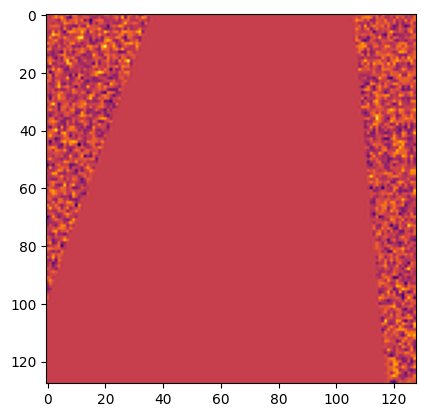

In [666]:
def create_anisotropic_noise(noise, sigma_x, sigma_y, angle):
    """
    Create a 2D square image of random Gaussian noise with anisotropy.

    Parameters:
    - noise: gaussian noise input
    - sigma_x: float, standard deviation of the Gaussian filter along the x-axis
    - sigma_y: float, standard deviation of the Gaussian filter along the y-axis
    - angle: float, angle in degrees to rotate the anisotropy direction

    Returns:
    - anisotropic_image: 2D numpy array, the anisotropic noise image
    """
    # Generate random Gaussian noise
    #noise = np.random.normal(0, 1, (image_size, image_size))

    # Apply Gaussian filter with different sigma_x and sigma_y
    anisotropic_image = gaussian_filter(noise, sigma=(sigma_x, sigma_y))

    # Rotate the image to align the anisotropy with the specified angle
    from scipy.ndimage import rotate
    anisotropic_image = rotate(anisotropic_image, angle, reshape=False, mode='mirror')

    return anisotropic_image

np.random.seed(42)
initialConditionA=np.random.normal(loc=mean, scale=std,size=(sizeX,sizeY))
initialConditionA[:, 128//8:] = 0.0
initialConditionB=np.random.normal(loc=mean, scale=std,size=(sizeX,sizeY))
initialConditionB[:, :-128//8] = 0.0
sigX, sigY = (0, 0)
aniso_imgA = create_anisotropic_noise(initialConditionA, sigX, sigY, -20)
aniso_imgB = create_anisotropic_noise(initialConditionB, sigX, sigY, 5)
aniso_img = aniso_imgA + aniso_imgB
plt.imshow(aniso_img, cmap='inferno')

In [ ]:

# initialCondition=np.random.normal(loc=mean, scale=std,size=(sizeX,sizeY))
# plt.imshow(initialCondition, cmap='inferno')

In [702]:
a=0.2
b=0.246
c=0.53
mean=0.0
std=.01
sizeX=128
sizeY=128
startTime = 0
finalTime = 250
steps =finalTime*50
storeInterval = 100
simulationResults=simulateSwiftHohenberg(a,b,c,startTime,finalTime,steps,storeInterval, aniso_img)

Shows final spatial distribution. We can analyze how long it takes for the mode to stablize by running the blocks.

Observations:
- Use of constant 0 boundary conditions creates the "cuff" in the power spectrum which we observe in the original data. Which simply comes from it not being periodic.
- Try anisotropic initial conditions

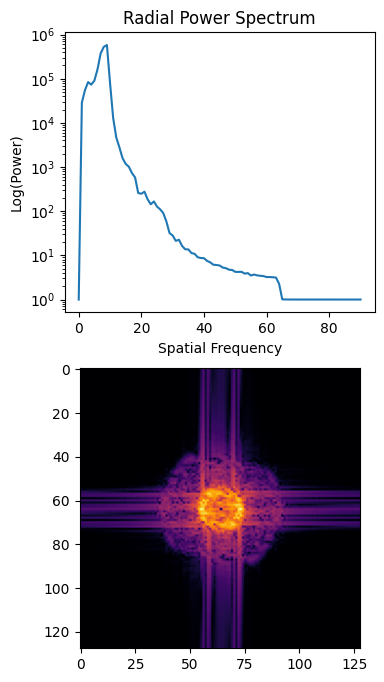

In [709]:
len(simulationResults)
curr_result = simulationResults[-1]
radial_profile, df, ps = get_radial_profile(curr_result)
fig, ( ax2, ax3) = plt.subplots(nrows=2, figsize=(4,8))
# ax1.imshow(curr_result, cmap='inferno')
ax2.plot(radial_profile+1)
ax2.set_yscale('log')
ax2.set_xlabel('Spatial Frequency')
ax2.set_ylabel('Log(Power)')
ax2.set_title(f'Radial Power Spectrum')
ax3.imshow(np.log1p(ps), cmap='inferno')

In [713]:
(1/df)*128

14.222222222222221

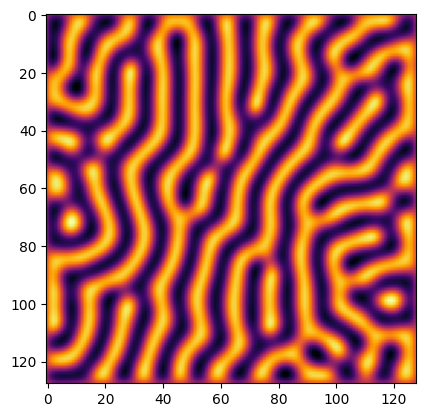

In [ ]:
# uncomment this line to evolve by 50 time steps
# finalTime = 50
# steps = (finalTime-startTime)*50
# simulationResults=simulateSwiftHohenberg(a,b,c,startTime,50,steps,storeInterval,simulationResults[-1])

plt.imshow(curr_result, cmap='inferno')

[Fast way of computing radial profile](https://stackoverflow.com/questions/21242011/most-efficient-way-to-calculate-radial-profile)

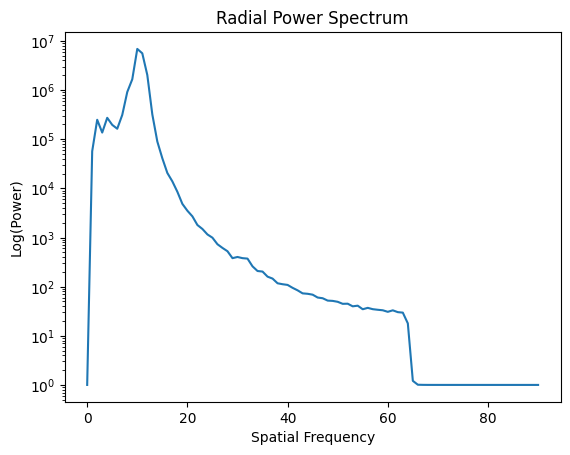

In [ ]:
radial_profile, df, ps = get_radial_profile(curr_result)
plt.plot(radial_profile+1)
plt.yscale('log')
plt.xlabel('Spatial Frequency')
plt.ylabel('Log(Power)')
plt.title(f'Radial Power Spectrum')
# plt.savefig(os.path.join('data1', f'rps_ds{ds}.png'))
plt.show()

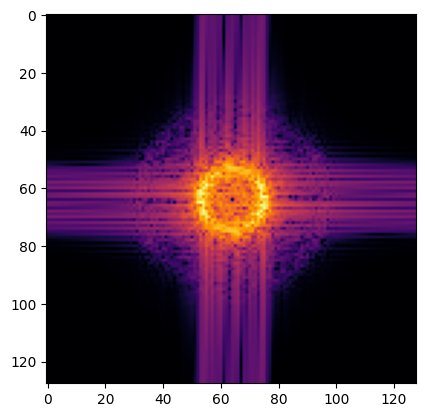

In [632]:
plt.imshow(np.log1p(ps), cmap='inferno')

Loop time

In [700]:
a_values = np.linspace(0.2, 0.7, 6)  # Example values for a
b_values = np.linspace(0.01, 0.6,6)  # Example values for b
c_values = np.linspace(0.4, 0.8, 41)  # Example values for c

# estimated 4 hours to finish...

In [701]:
# Define the parameter ranges to loop over
# a_values = np.arange(0.2, 0.7, 6)  # Example values for a
# b_values = np.arange(0.01, 0.2,5)  # Example values for b
# c_values = np.arange(0.4, 0.8, 40)  # Example values for c

# Fixed parameters
mean = 0.0
std = 0.01
sizeX = 128
sizeY = 128
startTime = 0
finalTime = 250
steps = finalTime * 50
storeInterval = 100

# Loop over potential values of a, b, c
for a in a_values:
    for b in b_values:
        for c in c_values:
            # Run the simulation
            simulationResults = simulateSwiftHohenberg(a, b, c, startTime, finalTime, steps, storeInterval, aniso_img)
            curr_result = simulationResults[-1]

            # Compute the radial profile and power spectrum
            radial_profile, df, ps = get_radial_profile(curr_result)

            # Create the figure
            fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16, 4))

            # Plot the current result
            ax1.imshow(curr_result, cmap='inferno')
            ax1.set_title(f'Simulation Result (a={a}, b={b}, c={c})')

            # Plot the radial profile
            ax2.plot(radial_profile + 1)
            ax2.set_yscale('log')
            ax2.set_xlabel('Spatial Frequency')
            ax2.set_ylabel('Log(Power)')
            ax2.set_title(f'Radial Power Spectrum (a={a}, b={b}, c={c})')

            # Plot the log-transformed power spectrum
            ax3.imshow(np.log1p(ps), cmap='inferno')
            ax3.set_title(f'Log Power Spectrum (a={a}, b={b}, c={c})')

            # Remove decimal points from a, b, c for the filename
            a_str = str(a).replace('.', '')
            b_str = str(b).replace('.', '')
            c_str = str(c).replace('.', '')

            # Save the figure
            plt.tight_layout()
            plt.savefig(f'simulations_initial_condition_01/simulation_a{a_str}_b{b_str}_c{c_str}.png')  # Save the figure with a unique filename
            plt.close()